### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. 

**Подключение библиотек и скриптов**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [4]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, delimiter=',')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [7]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [8]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

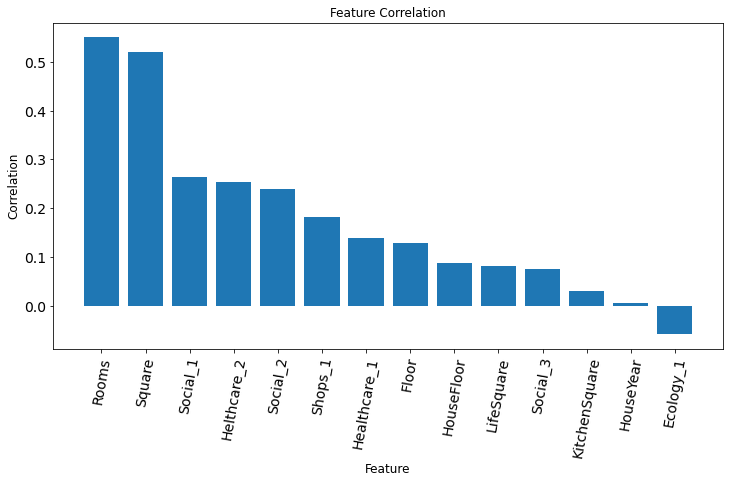

In [11]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='80')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Feature Correlation', fontsize=12)
plt.show()

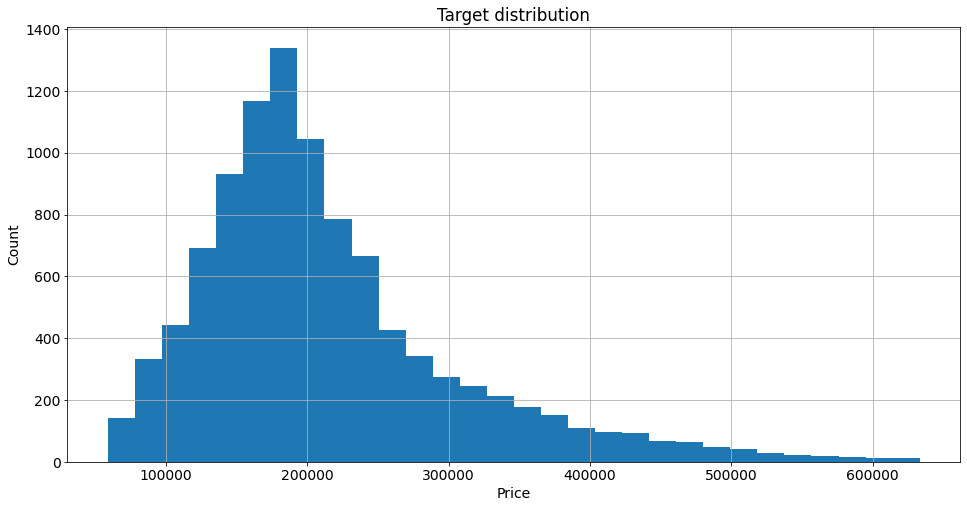

In [12]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [14]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

### 2. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [15]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.medians_rooms=None
        self.max_square_quantile = None
        self.min_square_quantile = None
        self.districts_healthcare = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.medians_rooms=round(X['Rooms'].median())
        self.max_square_quantile = X['Square'].quantile(.99)
        self.min_square_quantile = X['Square'].quantile(.01)
        self.districts_healthcare = train_df.groupby(['DistrictId'], as_index=True).agg({'Healthcare_1':'median'}).reset_index()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 5), 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X.loc[(X['KitchenSquare'] > 20), 'KitchenSquare'] = self.medians['KitchenSquare']
        # X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 4
        
        # Square
        condition = (X['Square'] > self.max_square_quantile) | (X['Square'] < self.min_square_quantile)
        X.loc[condition, 'Square'] = self.medians['Square']
            
        # LifeSquare
        X['LifeSquare_nan'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        condition = (X['LifeSquare'].isna() | (X['LifeSquare'] > 0) & (X['LifeSquare'] < 6))
        X.loc[condition, 'LifeSquare'] = self.medians['LifeSquare'] / self.medians['Square'] * X['Square']
        X.loc[(X['LifeSquare'] > X['Square']), 'LifeSquare'] = self.medians['LifeSquare'] / self.medians['Square'] * X['Square']
        
        # HouseFloor, Floor
        X.loc[(X['HouseFloor'] > 30) | (X['HouseFloor'] == 0), 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] == 0, 'Floor'] = self.medians['Floor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = self.medians['Floor']
        
        # HouseYear
        current_year = datetime.now().year
        condition_year = (X['HouseYear'] > current_year) | (X['HouseYear'] < 1950)
        X.loc[condition_year, 'HouseYear'] = self.medians['HouseYear']
        
        # Ecology
        X.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        X.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        X.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.districts_healthcare.set_index('DistrictId')['Healthcare_1'])
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = self.medians['Healthcare_1']

        
        X.fillna(self.medians, inplace=True)
        
        # Drop Id
        X.drop(['Id'], axis=1, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

In [16]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.max_floor_quantile = None
        self.min_floor_quantile = None
        self.district_is_large = None
        self.district_houseyear_price = None
        self.med_price_per_square = None

    def fit(self, X, y=None):
        
        X = X.copy()
        # HouseFloor
        if y is not None:    
            self.max_floor_quantile = X['HouseFloor'].quantile(.80)
            self.min_floor_quantile = X['HouseFloor'].quantile(.20)

        df = X.copy()
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_per_square = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPricePerSquare'})
            
            self.med_price_per_square_median = self.med_price_per_square['MedPricePerSquare'].median()
        
        if y is not None:
            df['Price'] = y.values
            
            self.district_houseyear_price = train_df.groupby(['DistrictId', 'HouseYear'],\
                           as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'District_HouseYear_Price'})
           
            self.district_houseyear_price_median = self.district_houseyear_price['District_HouseYear_Price'].median()   
            
       
    def transform(self, X):
        
        # HouseYearIs60-70
        X['HouseYearIs60_70'] = 0
        X.loc[(train_df['HouseYear'] > 1960) & (X['HouseYear'] < 1980), 'HouseYearIs60_70'] = 1
        
        # Square
        if self.med_price_per_square is not None:
            X = X.merge(self.med_price_per_square, on=['DistrictId'], how='left')
            X.fillna(self.med_price_per_square_median, inplace=True)
            
        if self.district_houseyear_price is not None:
            X = X.merge(self.district_houseyear_price, on=['DistrictId', 'HouseYear'], how='left')
            X.fillna(self.district_houseyear_price_median, inplace=True)
        
        # Large_Kitchen
        X['Large_Kitchen'] = 0
        X.loc[(X['KitchenSquare'] > 8), 'Large_Kitchen'] = 1
       
        # Floor
        X['Popular_Floors'] = 0
        condition = ((X['Floor'] < self.max_floor_quantile) & (X['Floor'] > self.min_floor_quantile))
        X.loc[condition, 'Popular_Floors'] = 1
        
        # Scale
        scaler = RobustScaler()
        cols_for_scaling = ['Social_1','Social_2','Social_3']
        if y is not None:
            X[cols_for_scaling] = scaler.fit_transform(X[cols_for_scaling])
        else:
            X[cols_for_scaling] = scaler.transform(X[cols_for_scaling])
        
        return X
    
    

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [17]:
feature_names = ['Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor', 'HouseYear','Ecology_1','Ecology_2','Ecology_3','Social_1','Social_2','Social_3','Healthcare_1','Helthcare_2','Shops_1','Shops_2']
new_feature_names = ['HouseYearIs60_70', 'Large_Kitchen', 'LifeSquare_nan', 'Popular_Floors', 'District_HouseYear_Price', 'MedPricePerSquare']
target_name = 'Price'

In [18]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [20]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [21]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [22]:
X_train.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'LifeSquare_nan',
 'HouseYearIs60_70',
 'MedPricePerSquare',
 'District_HouseYear_Price',
 'Large_Kitchen',
 'Popular_Floors']

In [23]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [24]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [25]:
gb_model_GCV = GradientBoostingRegressor(criterion='mse',
                                     min_samples_leaf=50,
                                     random_state=42)

In [26]:
# %%time
# params = {'n_estimators':[100, 200, 300, 400], 
#           'max_depth':[5, 6, 7, 8, 10],
#          'max_features':[7,8,9,10, 'sqrt']}

# gs = GridSearchCV(gb_model_GCV, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,
#                            random_state=42, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

In [27]:
# gs.best_params_

In [28]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=6,
                                        max_features='sqrt',
                                        min_samples_leaf=50,
                                        random_state=42,
                                        n_estimators=150)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=6, max_features='sqrt',
                          min_samples_leaf=50, n_estimators=150,
                          random_state=42)

**Оценка модели**

Train R2:	0.885
Test R2:	0.828


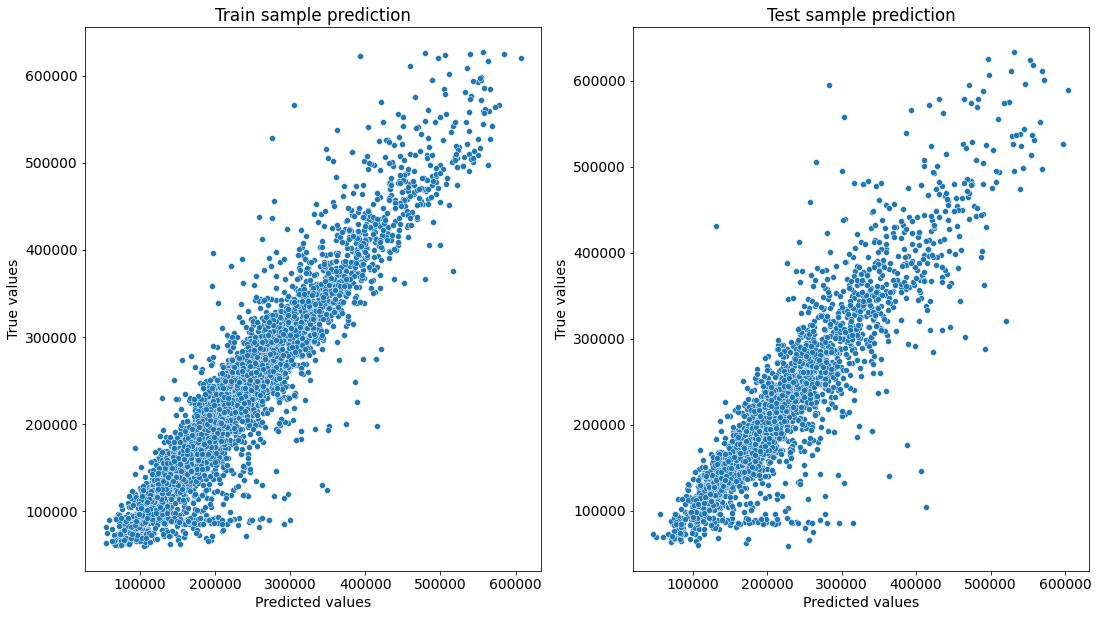

In [29]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [30]:
cv_score = cross_val_score(final_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.82558925, 0.79481202, 0.82376964])

In [31]:
cv_score.mean()

0.81472363797939

**Важность признаков**

In [32]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
21,District_HouseYear_Price,0.319719
1,Square,0.137641
22,MedPricePerSquare,0.125075
0,Rooms,0.119931
2,LifeSquare,0.102683
12,Social_3,0.041189
11,Social_2,0.029517
10,Social_1,0.025174
3,KitchenSquare,0.021252
15,Shops_1,0.014387


### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [33]:
test_df.shape

(5000, 23)

In [34]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [35]:
predictions = final_model.predict(test_df)
predictions

array([175373.87343213, 132325.70996717, 148679.9807286 , ...,
       156641.96172269, 194099.53244229, 238721.43835089])

In [36]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,175373.873432
1,5925,132325.709967
2,960,148679.980729
3,3848,176641.672069
4,746,194304.781571


In [37]:
submit.to_csv('gb_submit.csv', index=False)